**This notebook is about**:
* Trying out the UK Open Data API
* Requesting data on corona virus from [GOV.UK Coronavirus(COVID-19) Open Data API](https://coronavirus.data.gov.uk/details/developers-guide/main-api)
* Doing some pretty quick and dirty data exploration
* Getting some simple statistics
* Visualising the results

### Visual Summaries in this notebook
* Regional Yearly Tally of Covid-19 Cases
* Nation-wide monthly Tally of Covid-19 Cases
* Daily Variation in the number of Covid-19 Cases
* Aggregate Tally of Covid-19 Cases by Region
* Pie Chart representing Aggregate Tally of Covid-19 Cases by Region

In [1]:
from api import get_paginated_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
query_filters = [f'areaType=region']
query_structure = {"date": "date",
                   "name": "areaName",
                   "code": "areaCode",
                   "daily": "newCasesBySpecimenDate",
                   "cumulative": "cumCasesBySpecimenDate"
                  }

#### Get the data in json

In [3]:
json_data = get_paginated_dataset(query_filters, query_structure)

In [4]:
print(f'Length: {len(json_data)}')
print(f'Data (first 3 items):\n{json_data[:3]}')

Length: 12631
Data (first 3 items):
[{'date': '2023-12-12', 'name': 'North West', 'code': 'E12000002', 'daily': 56, 'cumulative': 2868790}, {'date': '2023-12-11', 'name': 'North West', 'code': 'E12000002', 'daily': 120, 'cumulative': 2868734}, {'date': '2023-12-10', 'name': 'North West', 'code': 'E12000002', 'daily': 106, 'cumulative': 2868614}]


**Save the data to disk**

In [5]:
with open('./data/data.json', 'wt') as f:
    json.dump(json_data, f)

**Load and analyse data**

**Read the data from disk and create a DataFrame**

In [6]:
df = pd.read_json('./data/data.json').set_index('date')
print(df.shape)
df.head()

(12631, 4)


,name,code,daily,cumulative
date,,,,
2023-12-12,North West,E12000002,56,2868790
2023-12-11,North West,E12000002,120,2868734
2023-12-10,North West,E12000002,106,2868614
2023-12-09,North West,E12000002,77,2868508
2023-12-08,North West,E12000002,83,2868431


**Create columns for year, month and day**

In [7]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df.head()

,name,code,daily,cumulative,year,month,day
date,,,,,,,
2023-12-12,North West,E12000002,56,2868790,2023,12,12
2023-12-11,North West,E12000002,120,2868734,2023,12,11
2023-12-10,North West,E12000002,106,2868614,2023,12,10
2023-12-09,North West,E12000002,77,2868508,2023,12,9
2023-12-08,North West,E12000002,83,2868431,2023,12,8


In [8]:
df.rename(columns = {'name': 'region'}, inplace = True) 
df.drop(columns = ['code'], inplace = True)
df.head()

,region,daily,cumulative,year,month,day
date,,,,,,
2023-12-12,North West,56,2868790,2023,12,12
2023-12-11,North West,120,2868734,2023,12,11
2023-12-10,North West,106,2868614,2023,12,10
2023-12-09,North West,77,2868508,2023,12,9
2023-12-08,North West,83,2868431,2023,12,8


## Regional Yearly Tally

In [9]:
regional_yearly = df.groupby(['region', 'year'])['daily'].sum().unstack()
regional_yearly.head()

year,2020,2021,2022,2023
region,,,,
East Midlands,196447,824623,722122,51038
East of England,216743,1021087,1007072,62936
London,422965,1532909,1163023,62450
North East,130128,458160,440308,30033
North West,388456,1355569,1049646,75119


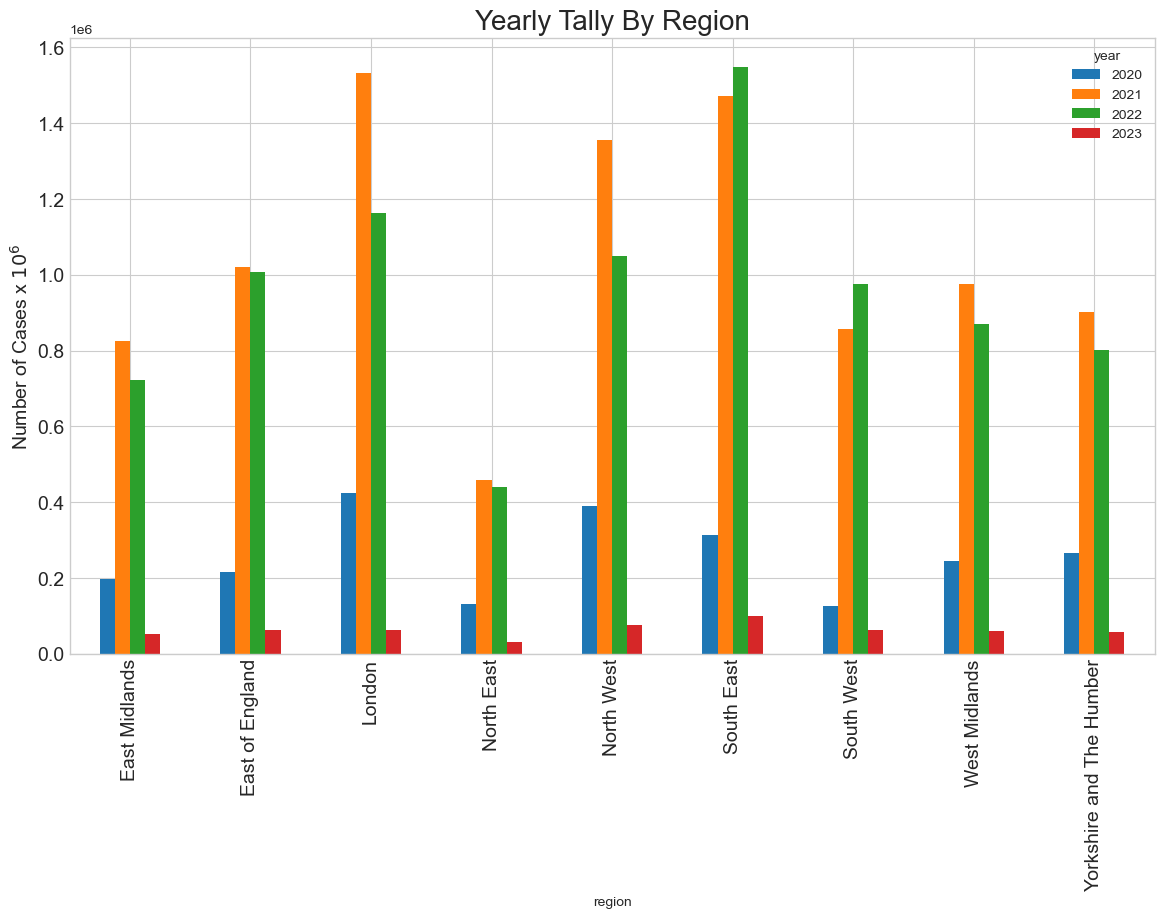

In [10]:
regional_yearly.plot(kind = 'bar', figsize = (14, 8), fontsize = 14)
plt.title('Yearly Tally By Region', fontsize = 20)
plt.ylabel('Number of Cases x $10^6$', fontsize = 14)
plt.show()

The chart shows that: 
* **All regions were at peak period in 2021**
* The **least** affected region is **North East**

### Nation-wide monthly Tally

In [11]:
national_monthly = df.groupby(['year', 'month'])['daily'].sum().unstack().fillna(0)
national_monthly.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
national_monthly.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
year,,,,,,,,,,,,
2020,1,54,31528,112508,66905,25202,19211,30064,127351,485065,531897,871682
2021,1101254,301061,141040,62829,64408,302943,950643,796032,776226,1067889,1024853,2805130
2022,3194643,1097134,1774998,649751,198242,382530,522816,149220,147955,211393,91029,155638
2023,81020,94345,116597,51215,31828,13012,14075,30820,53193,46109,18036,9446


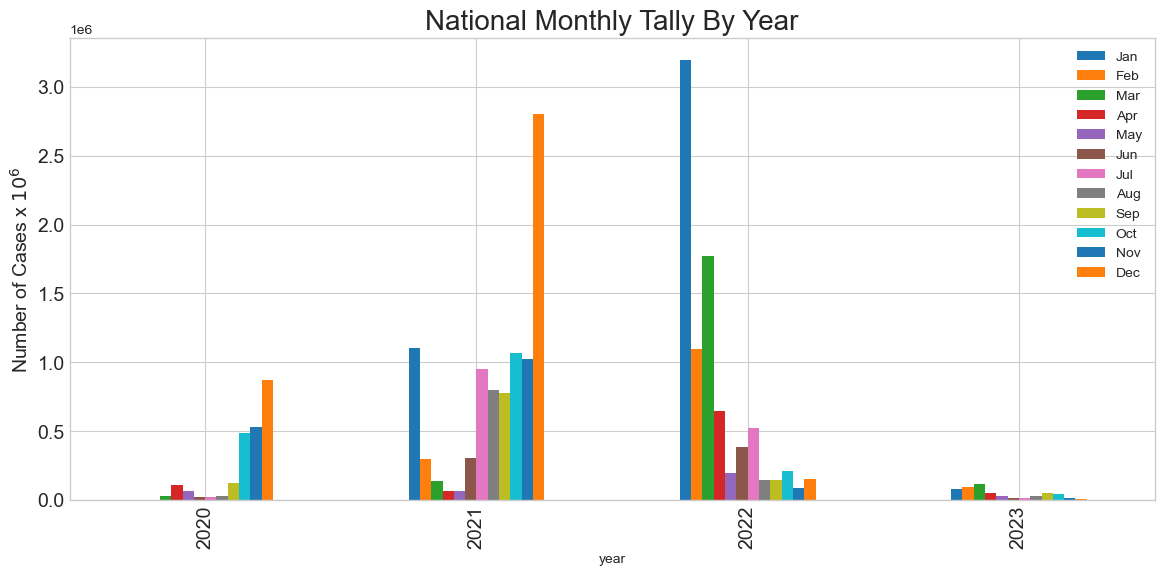

In [12]:
national_monthly.plot(kind = 'bar', figsize = (14, 6), fontsize = 14)
plt.title('National Monthly Tally By Year', fontsize = 20)
plt.ylabel('Number of Cases x $10^6$', fontsize = 14)
plt.show()

* The disproportionate high cases in **December 2021 - January 2022** is due to the outbreak of the **omicron** variant. 
* There was a **general decline** in the number of cases in **Feb 2022** followed by a sudden rise in **March 2022**.
* There has been a significant drop in the number of infection since **`August 31, 2022`** with a drastic drop in **`November and December 2022`**.

**Considering the degree of prevalence of the diesease, it is highly likely that most of the positive test results in 2023 are `false positives` (FPs). It is therefore highly recommended that mandatory tests should be halted! Tests should only be conducted on patients and probably only in hospitals.**

#### Daily Variation in the number of cases

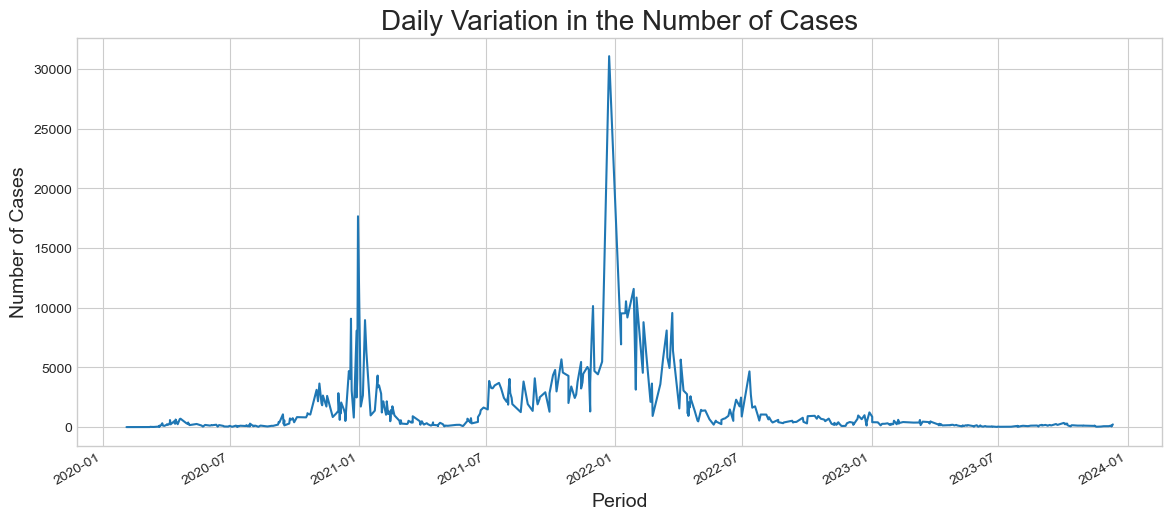

In [13]:
plt.figure(figsize = (14, 6))
df.daily.sample(500).plot()
plt.ylabel('Number of Cases', fontsize = 14)
plt.xlabel('Period', fontsize = 14)
plt.title('Daily Variation in the Number of Cases', fontsize = 20)
plt.show()

**The daily statistics agrees with the monthly tally above with spikes in the periods `December - January` which saw the outbreak of `Delta`and `Omicron`variants respectively. The curve has been relatively flat since the Q3 of 2022.**

#### The infection rate has dropped significantly as of `November 30, 2022`

### Aggregate Tally by Region
This actually recreates the column **`cumulative`** in the data!

In [14]:
regional_agg = df.groupby(['region'])['daily'].sum().sort_values(ascending = False).to_frame()
regional_agg.rename(columns = {'daily': 'total'}, inplace = True) 
regional_agg

,total
region,
South East,3429182
London,3181347
North West,2868790
East of England,2307838
West Midlands,2146564
Yorkshire and The Humber,2025151
South West,2019090
East Midlands,1794230
North East,1058629


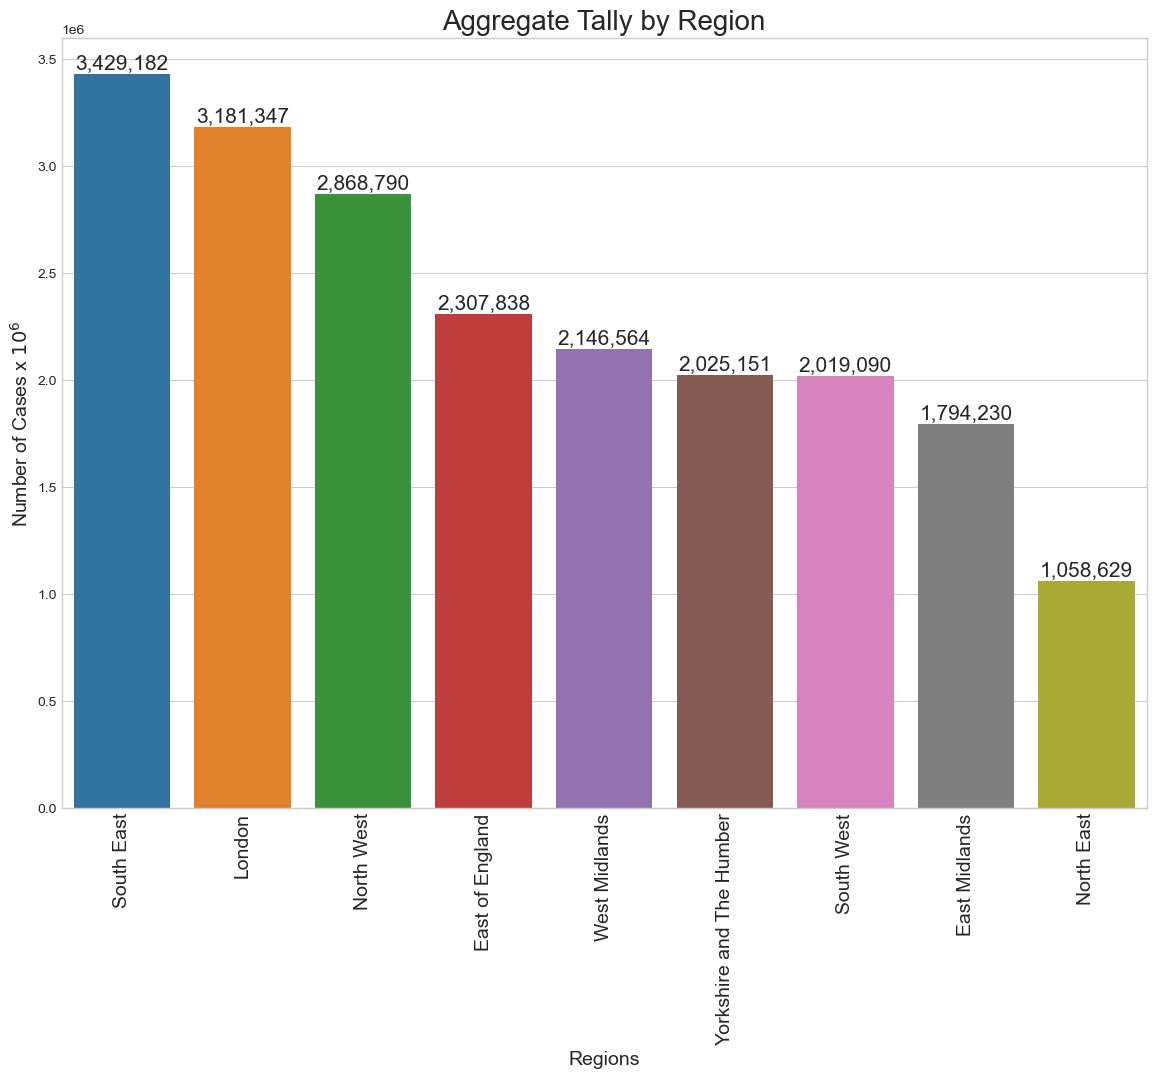

In [15]:
plt.figure(figsize = (14, 10))
plots = sns.barplot(x = regional_agg.index, y = regional_agg.total)
for bar in plots.patches:
    plots.annotate(f'{bar.get_height():,.0f}',
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()),    
                   ha = 'center', va = 'center',
                   size = 15, xytext = (0, 8),
                   textcoords = 'offset points')
plt.title('Aggregate Tally by Region', fontsize = 20)
plt.ylabel('Number of Cases x $10^6$', fontsize = 14)
plt.xlabel('Regions', fontsize = 14)
plt.xticks(rotation = 90, fontsize = 14)
plt.show()

**As can be seen on the Pareto chart, North East, the least hit region, is certain doing something different which is worth emulating...!!**

### Pie Chart representing same information as above

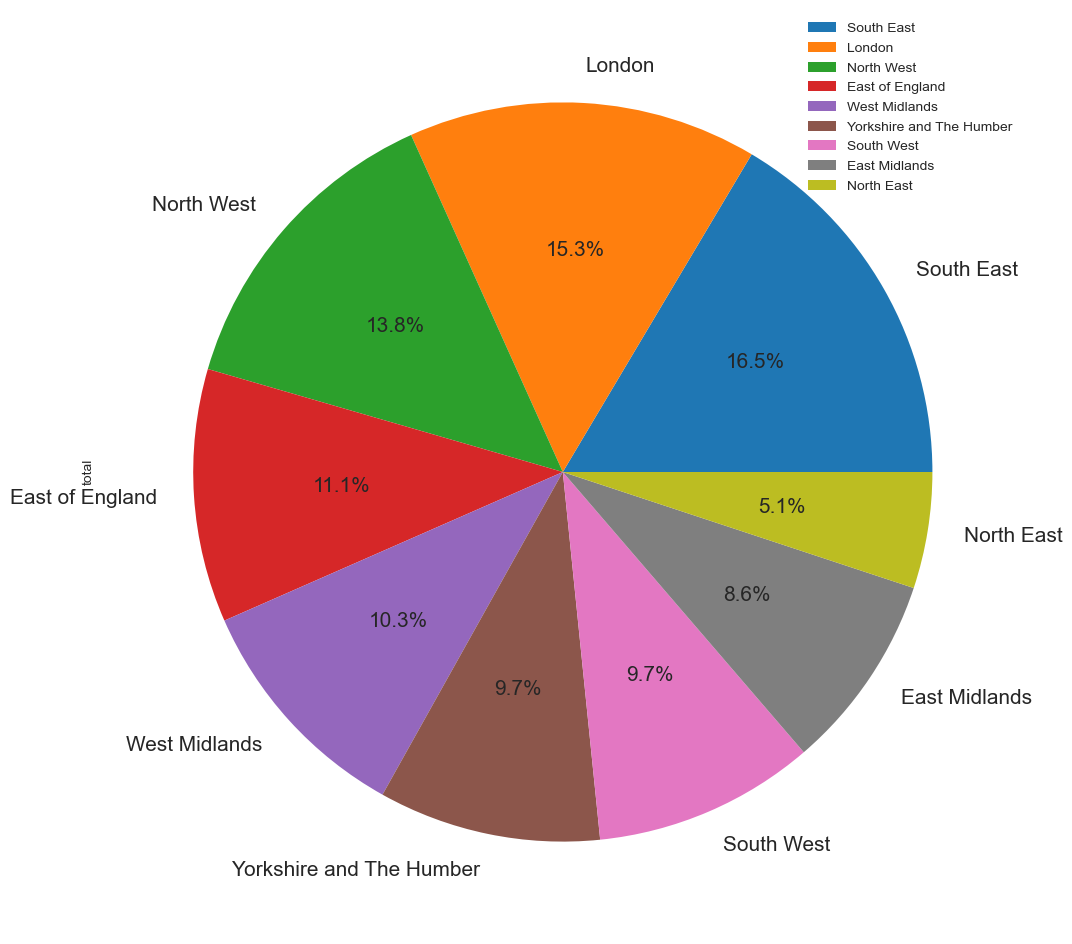

In [16]:
regional_agg.plot(kind = 'pie', subplots = True, figsize = (12, 12), autopct = '%1.1f%%', fontsize = 15)
plt.show()

**`South East`, `London` and `North West` are highly hit with `South East` being the most hit region as of `December 31, 2023`**. 